## Interpolate out Gaps in SST Data

In [2]:
#libraries
import datetime as dt
import xarray as xr
import numpy as np
import fsspec
import s3fs
import os.path
import matplotlib.pyplot as plt

# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


#### pull in data from the zarr store

In [4]:
%%time

file_location = 's3://ohw-bucket/goes_zarr'

ikey = fsspec.get_mapper(file_location,anon=False)

ds = xr.open_zarr(ikey) #,consolidated=True)

ds

CPU times: user 1.36 s, sys: 67.4 ms, total: 1.43 s
Wall time: 7.06 s


,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Just visualize how cloudy various parts of the ocean are

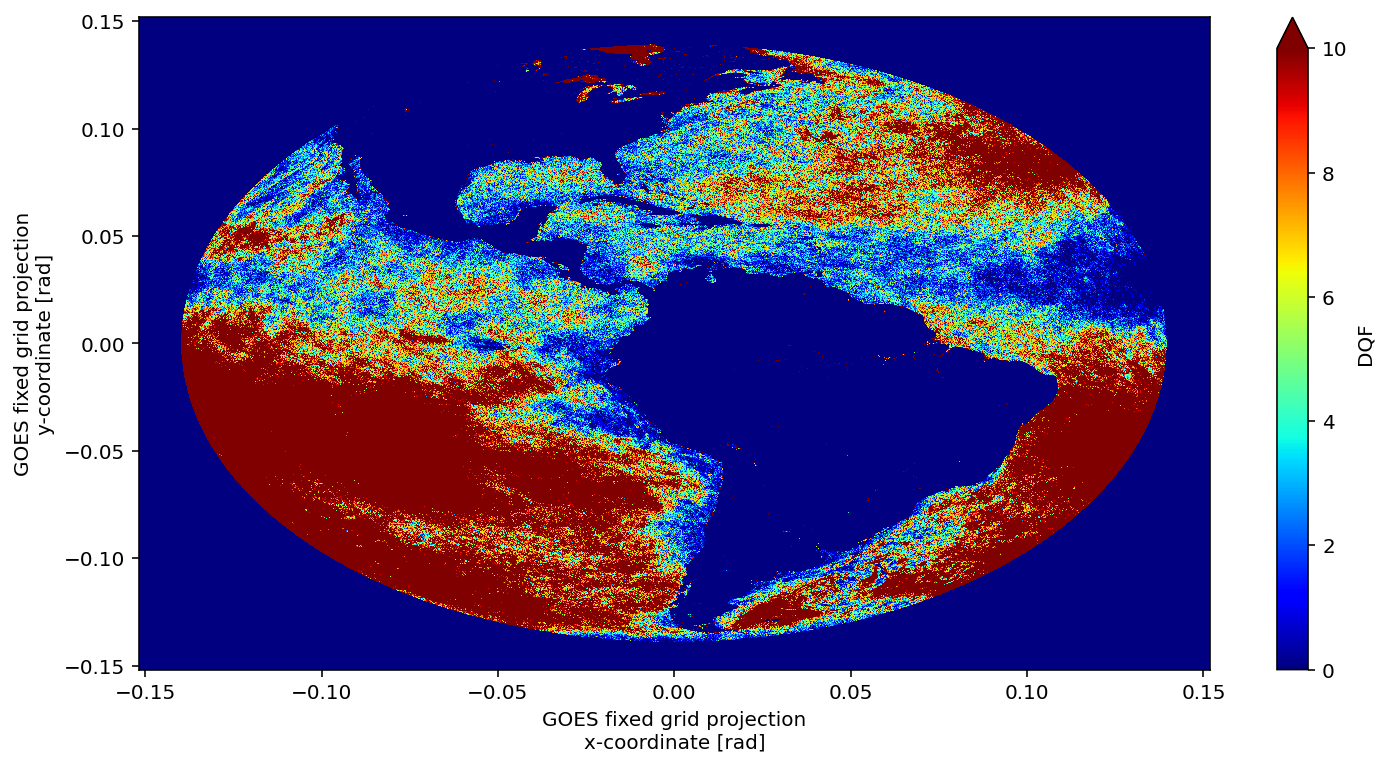

In [7]:
# sum up all the times DFQ isn't 0
masked = ds.where(ds.DQF!=3)
masked = masked.where(masked.DQF!=2)
sum_gaps = masked.DQF.sum('time',skipna=True)   #here I want all possible values so skipna=True
# plot it
sum_gaps.plot(cmap='jet',vmax=10)

Cut it down to the first 100 time steps around the Gulf Stream just to be more manageable

In [386]:
ds_subset = ds.isel(time=slice(0,24))
ds_subset

<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, time: 24, x: 5424, y: 5424)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * x                                                       (x) float32 -0.15...
  * y                                                       (y) float32 0.151...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (time, SST_day_night_emissive_bands) int8 dask.array<chunksize=(24, 4), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (time, SST_day_night_emissive_bands) float32 dask.array<chunksize=(24, 4), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (time, SST_night_only_emissive_band) int8 dask.array<chunksize=(24, 1), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (time, SST_night_only_emissive_band) float32 dask.array<chunksize=(24, 1), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    algorithm_product_version_container                     (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    day_solar_zenith_angle                                  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    day_solar_zenith_angle_bounds                           (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    goes_imager_projection                                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    maximum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_retrieved_Reynolds_SST_diff                        (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_sea_surface_temp                                   (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    minimum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    night_solar_zenith_angle                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    night_solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_height                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lon                          (time) float

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


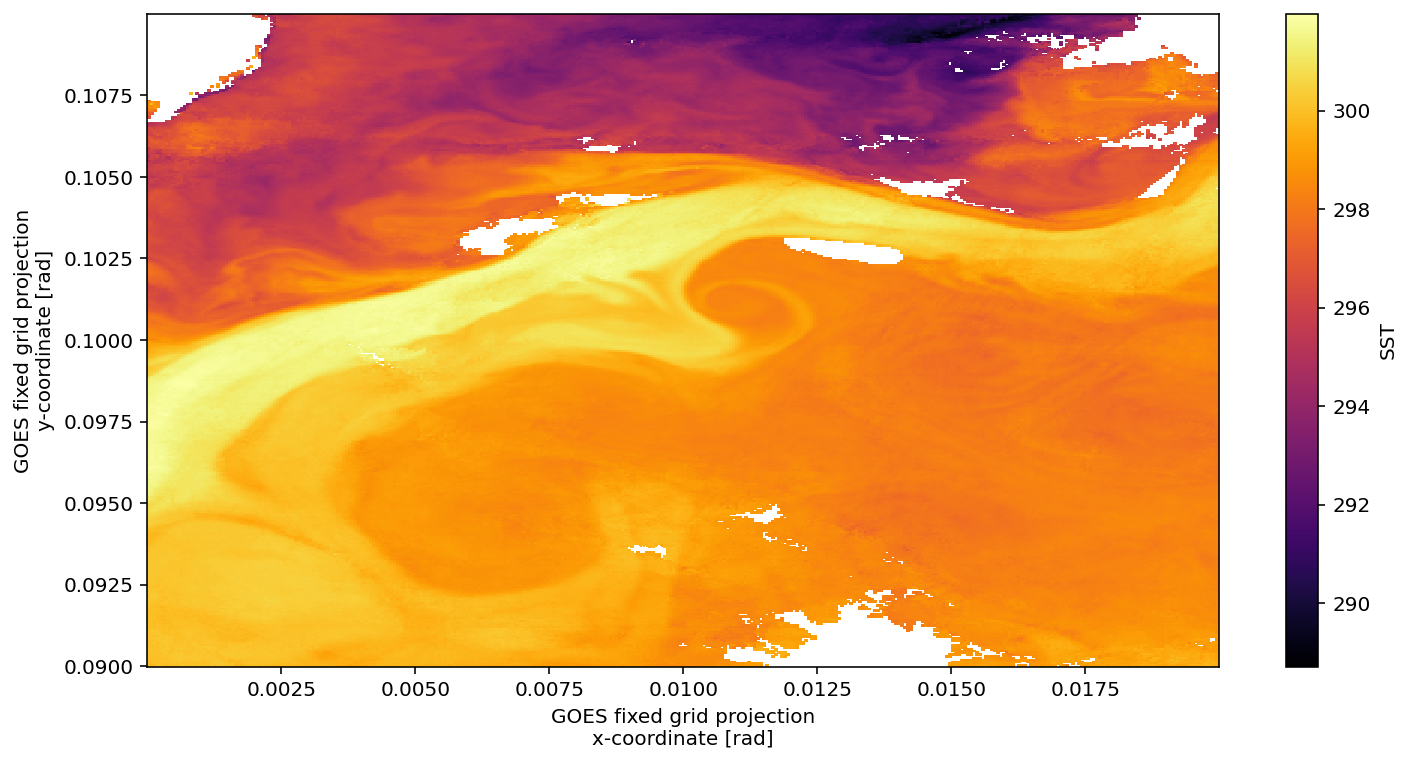

In [476]:
gs_subset = ds_subset.sel(x=slice(0.0,0.020),y=slice(0.110,0.090))  #reduce to GS region
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
mean_SST.plot(cmap='inferno')

Now pull out a bunch of random samples just because it takes forever otherwise

In [389]:
mean_SST

<xarray.DataArray 'SST' (y: 357, x: 357)>
dask.array<mean_agg-aggregate, shape=(357, 357), dtype=float32, chunksize=(357, 357), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 2.8014183e-05 8.401275e-05 ... 0.019908011 0.01996401
  * y        (y) float32 0.109956 0.1099 0.109844 ... 0.090076 0.09001999

In [434]:
import random
num_samples = 150

ys = random.choices(range(1, mean_SST.y.shape[0]-1), k=num_samples)
xs = random.choices(range(1, mean_SST.x.shape[0]-1), k=num_samples)

In [435]:
mean_SST.x[xs]

<xarray.DataArray 'x' (x: 150)>
array([0.000756, 0.01778 , 0.01554 , 0.014588, 0.00434 , 0.01834 , 0.016548,
       0.016884, 0.016268, 0.007028, 0.008316, 0.019348, 0.008988, 0.00406 ,
       0.015036, 0.017612, 0.014532, 0.003388, 0.008484, 0.002828, 0.012964,
       0.006916, 0.016492, 0.014308, 0.015036, 0.014476, 0.017108, 0.019068,
       0.000364, 0.007364, 0.018676, 0.000196, 0.015316, 0.00014 , 0.006748,
       0.010332, 0.003556, 0.016884, 0.002716, 0.003388, 0.01442 , 0.015316,
       0.002324, 0.01694 , 0.002772, 0.005404, 0.004844, 0.002996, 0.002212,
       0.019012, 0.000868, 0.00938 , 0.005852, 0.00322 , 0.012124, 0.018844,
       0.018732, 0.01946 , 0.011844, 0.011564, 0.016716, 0.010108, 0.0147  ,
       0.011452, 0.008372, 0.001372, 0.001148, 0.002156, 0.002436, 0.019404,
       0.004676, 0.00014 , 0.00462 , 0.008596, 0.007924, 0.0119  , 0.001148,
       0.00014 , 0.007084, 0.01834 , 0.01806 , 0.008036, 0.00126 , 0.001596,
       0.007532, 0.009884, 0.017276, 0.000252, 0.01778 , 0.007756, 0.004172,
       0.019516, 0.001652, 0.014364, 0.001932, 0.006804, 0.001428, 0.010052,
       0.005684, 0.002884, 0.012404, 0.007476, 0.001484, 0.019852, 0.010164,
       0.005964, 0.000532, 0.014252, 0.019572, 0.008316, 0.008988, 0.010108,
       0.00462 , 0.004116, 0.009268, 0.008092, 0.001596, 0.008428, 0.011844,
       0.003836, 0.006692, 0.01358 , 0.001708, 0.002716, 0.002884, 0.001092,
       0.000756, 0.013636, 0.00378 , 0.0189  , 0.006916, 0.011452, 0.008652,
       0.017836, 0.009492, 0.015652, 0.005964, 0.016492, 0.01078 , 0.011452,
       0.009324, 0.011788, 0.002436, 0.00798 , 0.019684, 0.012068, 0.019068,
       0.003612, 0.003276, 0.000756], dtype=float32)
Coordinates:
  * x        (x) float32 0.0007560104 0.017780006 ... 0.0032760054 0.0007560104
Attributes:
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate
    units:          rad

In [436]:
#x_locs = np.repeat(gs_subset.x.values[:, np.newaxis], gs_subset.y.shape, axis=1).flatten()
x_locs = mean_SST.x[xs]
#y_locs = np.repeat(gs_subset.y.values[:, np.newaxis], gs_subset.x.shape, axis=1).flatten()
y_locs = mean_SST.y[ys]
#data_flat = gs_subset.SST.values.flatten()
data_flat = mean_SST.values[xs,ys]

#x_locs.shape, y_locs.shape, data_flat.shape
len(x_locs), len(y_locs), len(data_flat)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(150, 150, 150)

In [441]:
krige_data = np.array([x_locs,y_locs, data_flat])
krige_data.shape

(3, 150)

Do we have any nans?

In [442]:
np.isnan(data_flat).any()

True

Cut out any samples that are nan

In [443]:
krige_data = krige_data[:,~np.isnan(krige_data).any(axis=0)]
krige_data.shape

(3, 140)

In [444]:
from pykrige.uk import UniversalKriging
import numpy as np

gridx = gs_subset.x.values
gridy = gs_subset.y.values

# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. Variogram is handled as in the ordinary kriging case.
# drift_terms is a list of the drift terms to include; currently supported terms
# are 'regional_linear', 'point_log', and 'external_Z'. Refer to
# UniversalKriging.__doc__ for more information.
UK = UniversalKriging(krige_data[0,:], krige_data[1,:], krige_data[2,:], variogram_model='exponential',
                      drift_terms=['regional_linear'], nlags=20)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See UniversalKriging.__doc__ for more information.)
z, ss = UK.execute('grid', gridx, gridy)

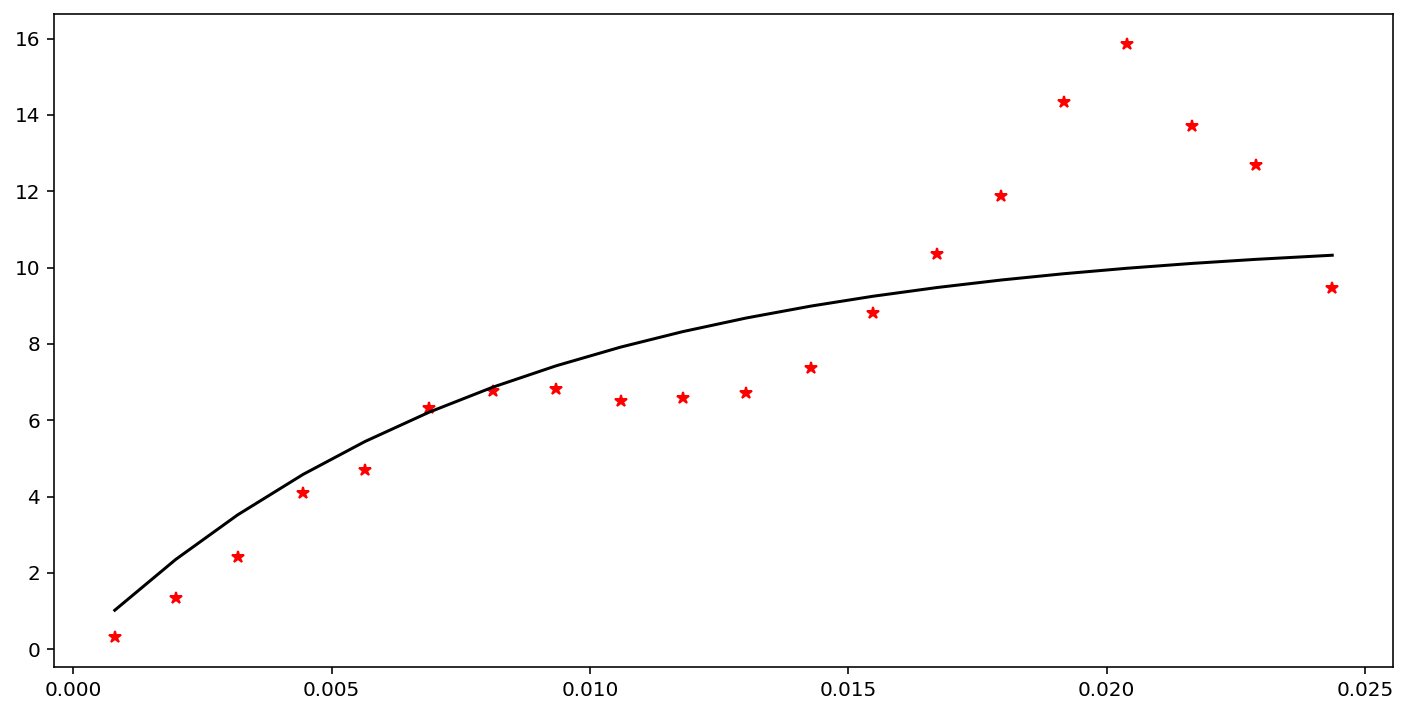

In [445]:
UK.display_variogram_model()

In [446]:
np.min(z), np.max(z)

(290.53808593751995, 301.4941067759756)

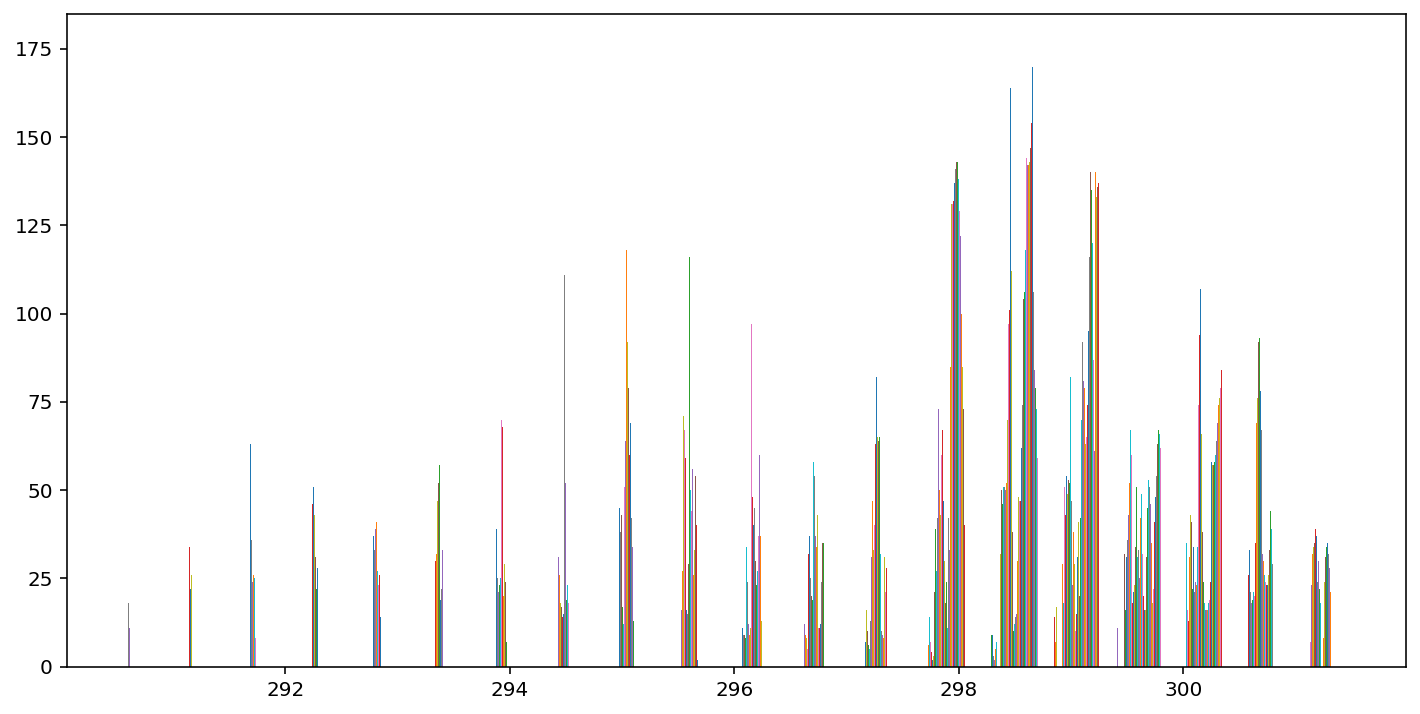

In [447]:
plt.hist(z, bins=20)
plt.show()

What does our interpolated SST map look like?

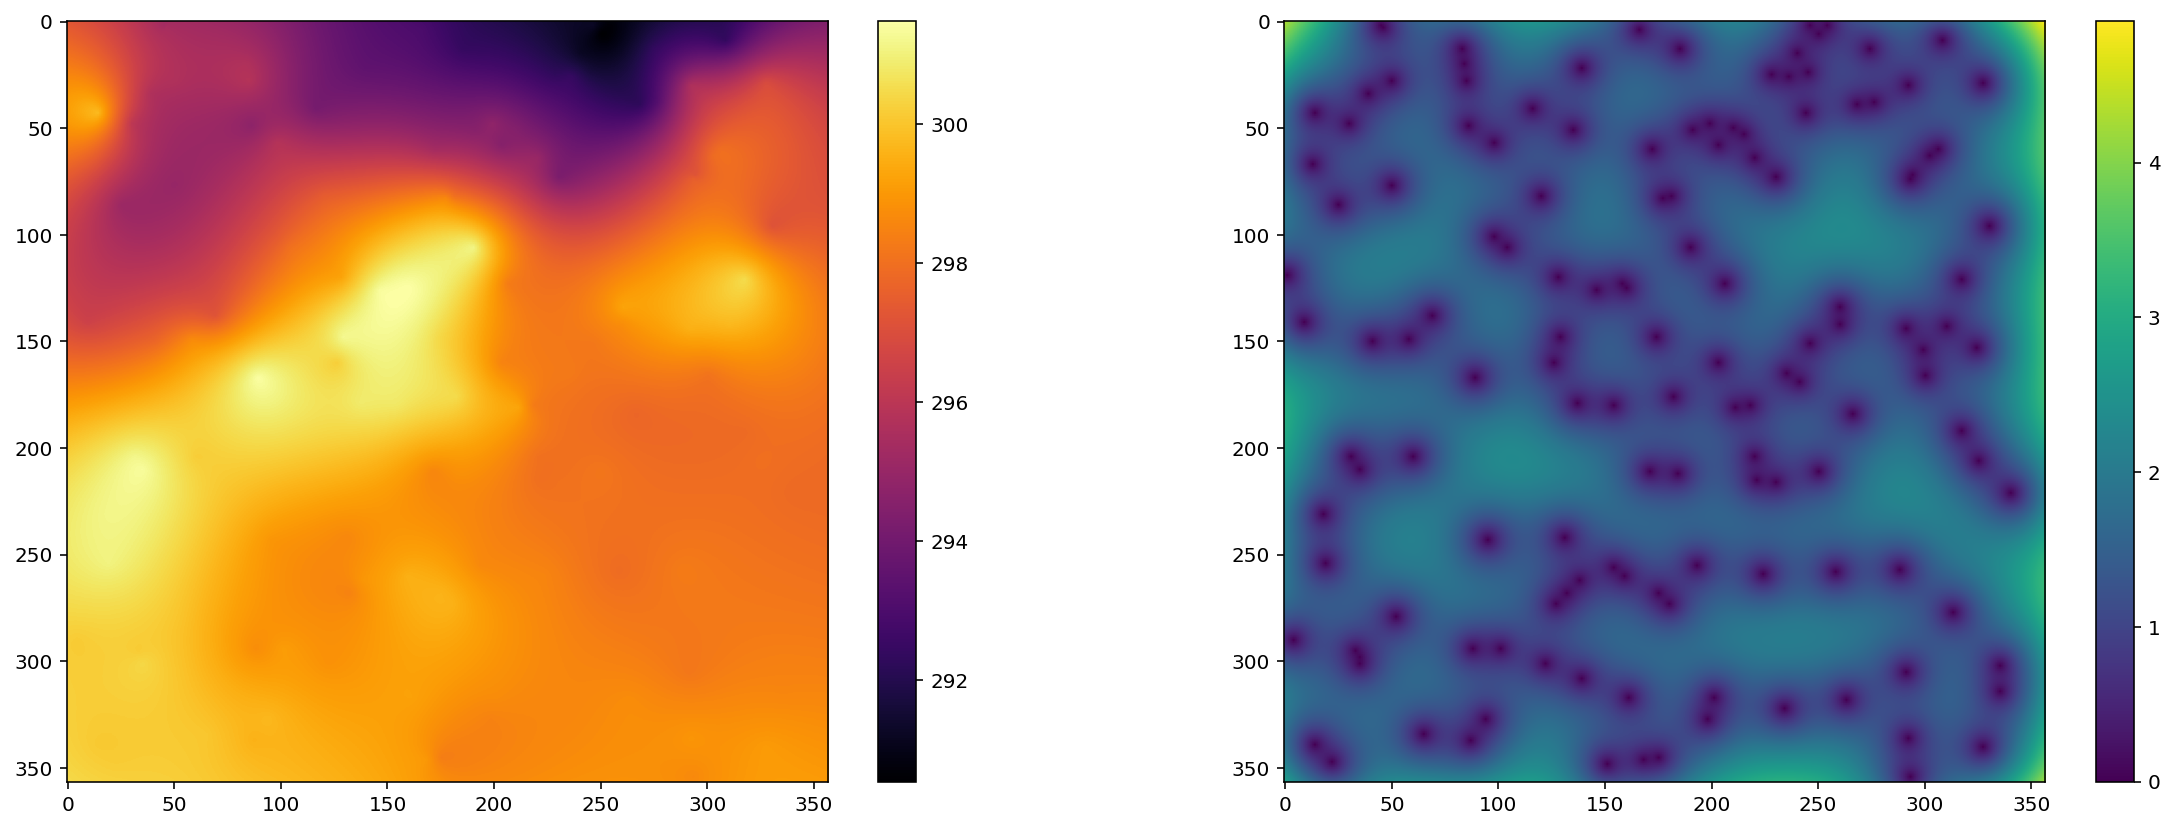

In [469]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

im1 = ax[0].imshow(z.T, cmap='inferno')
plt.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(ss.T)
plt.colorbar(im2, ax=ax[1])

What does variance look like?

How does the interpolated SST compare?

In [474]:
filled

<xarray.DataArray 'SST' (y: 357, x: 357)>
dask.array<where, shape=(357, 357), dtype=float64, chunksize=(357, 357), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 2.8014183e-05 8.401275e-05 ... 0.019908011 0.01996401
  * y        (y) float32 0.109956 0.1099 0.109844 ... 0.090076 0.09001999

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


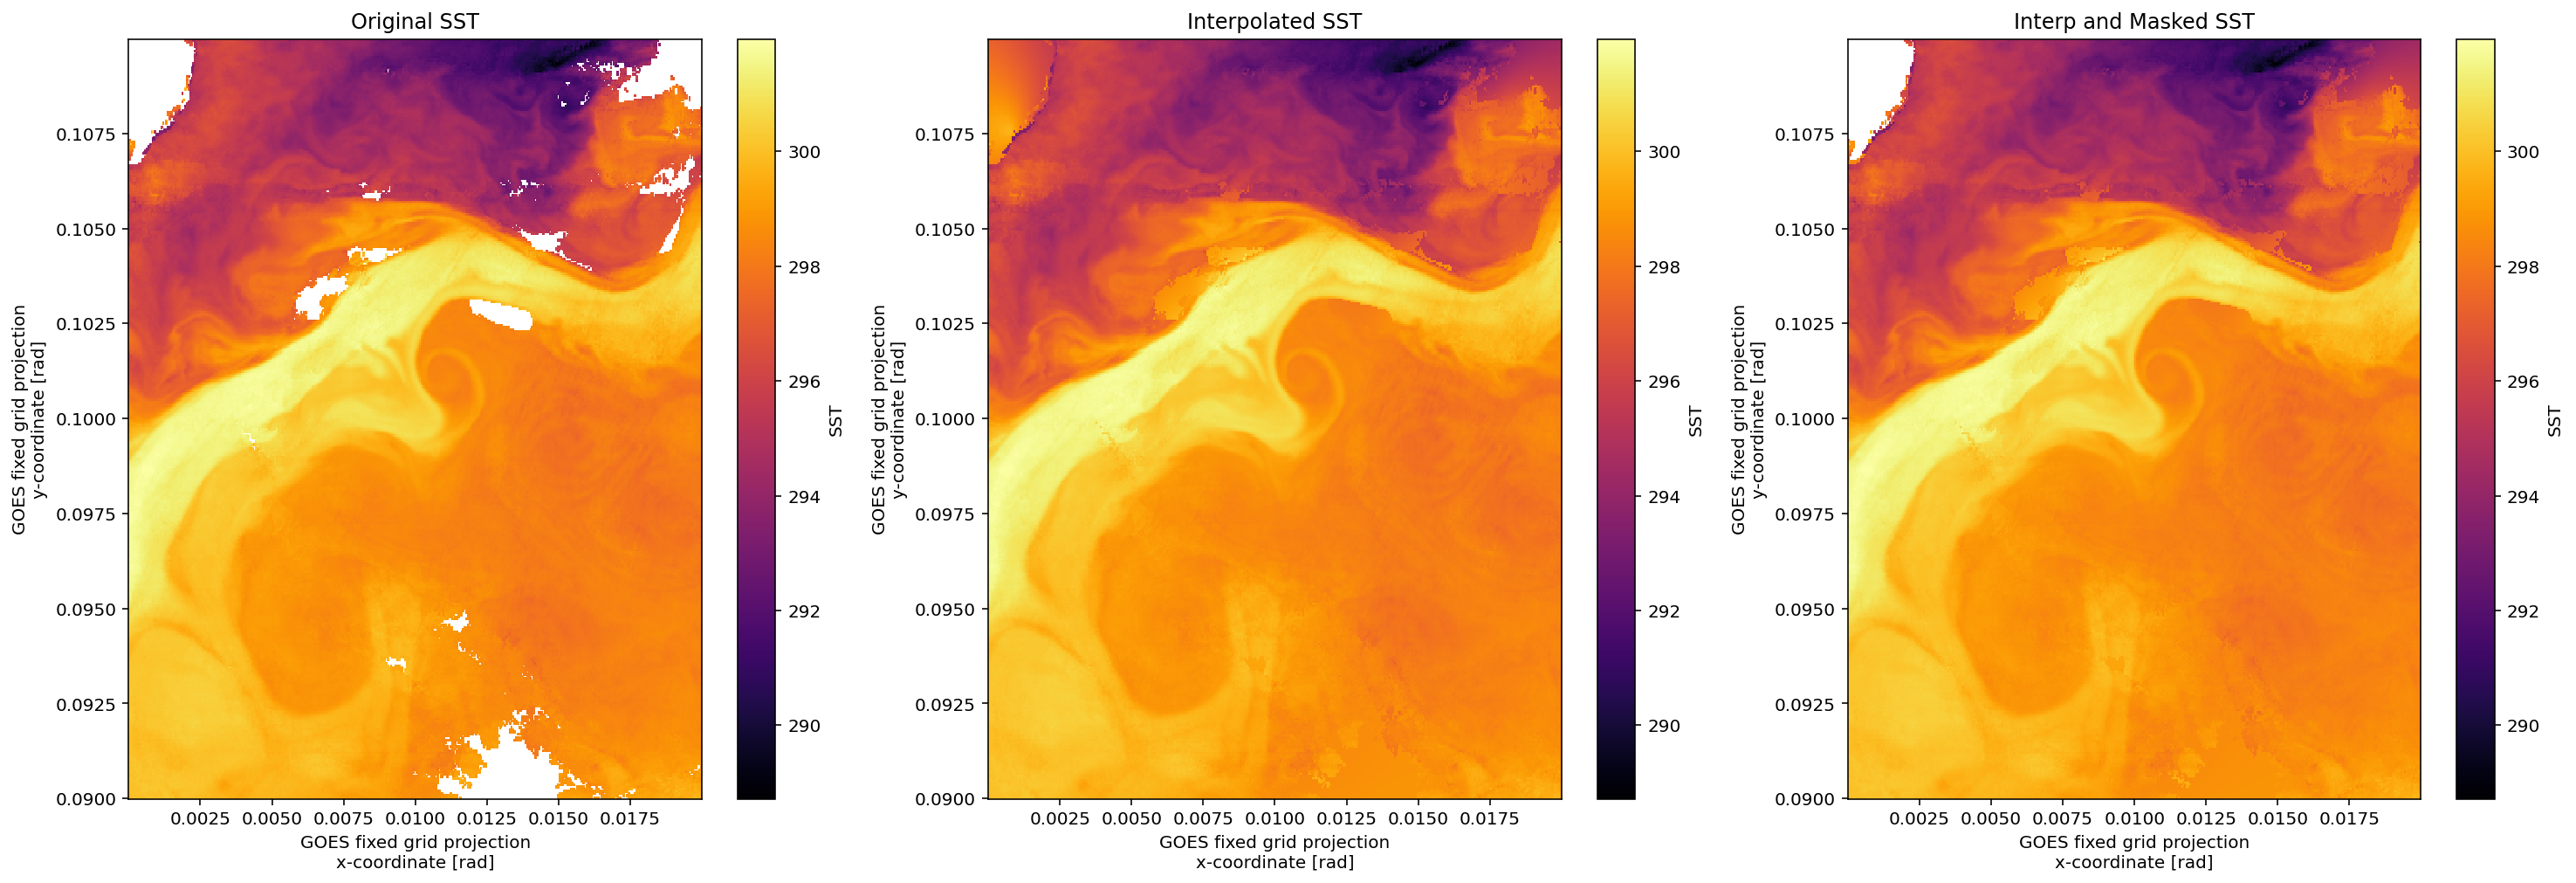

In [477]:
filled = mean_SST.fillna(z.T)

fig, ax = plt.subplots(1,3, figsize=(25,8))

mean_SST.plot(ax=ax[0],cmap='inferno')

filled.plot(ax=ax[1],cmap='inferno')

filled_masked = filled.where(gs_subset.isel(time=0).DQF!=3)
filled_masked.plot(ax=ax[2],cmap='inferno')

ax[0].set_title('Original SST')
ax[1].set_title('Interpolated SST')
ax[2].set_title('Interp and Masked SST')

plt.savefig('interpolated_comparison.png')

Not terrible... but we need the time component

In [29]:
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk3d import UniversalKriging3D
import numpy as np

data = np.array([[0.1, 0.1, 0.3, 0.9],
                                 [0.2, 0.1, 0.4, 0.8],
                                 [0.1, 0.3, 0.1, 0.9],
                                 [0.5, 0.4, 0.4, 0.5],
                                 [0.3, 0.3, 0.2, 0.7]])

gridx = np.arange(0.0, 0.6, 0.05)
gridy = np.arange(0.0, 0.6, 0.01)
gridz = np.arange(0.0, 0.6, 0.1)

# Create the 3D ordinary kriging object and solves for the three-dimension kriged
# volume and variance. Refer to OrdinaryKriging3D.__doc__ for more information.
ok3d = OrdinaryKriging3D(data[:, 0], data[:, 1], data[:, 2], data[:, 3],
                                                 variogram_model='linear')
k3d, ss3d = ok3d.execute('grid', gridx, gridy, gridz)

# Create the 3D universal kriging object and solves for the three-dimension kriged
# volume and variance. Refer to UniversalKriging3D.__doc__ for more information.
uk3d = UniversalKriging3D(data[:, 0], data[:, 1], data[:, 2], data[:, 3],
                                                  variogram_model='linear', drift_terms=['regional_linear'])
k3d, ss3d = uk3d.execute('grid', gridx, gridy, gridz)

In [31]:
k3d.shape

(6, 60, 12)